# RCNN Model

In [1]:
TRAINING_DIR_PATH = "./training"
LABEL_MAP_PATH = f"{TRAINING_DIR_PATH}/label_map.pbtxt"
TRAIN_DATA_PATH = "../Data/Train"
TEST_DATA_PATH = "../Data/Test"

# Label Map

In [2]:
labels = [
    {'name':'drone', 'id':1},
    {'name':'bird', 'id':2},
    {'name':'plane', 'id':3},
    {'name':'heli', 'id':4},
    {'name':'insect', 'id':5},
]

with open(LABEL_MAP_PATH, 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# TF records

In [4]:
!python ../xml_to_record.py -x {TRAIN_DATA_PATH} -l {LABEL_MAP_PATH} -o "{TRAINING_DIR_PATH}/train.record"
!python ../xml_to_record.py -x {TEST_DATA_PATH} -l {LABEL_MAP_PATH} -o "{TRAINING_DIR_PATH}/test.record"

Successfully created the TFRecord file: ./training/train.record
Successfully created the TFRecord file: ./training/test.record


# Models

Models can be selected from Tensorflow model zoo: 

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

and should be placed into **rcnn/models/** directory

In [3]:
DOWNLOADED_MODEL_PATH = "./models/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8"

# Config

In [4]:
import shutil
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [5]:
# Copy config
CONFIG_PATH = f"{TRAINING_DIR_PATH}/pipeline.config"
shutil.copy2(f"{DOWNLOADED_MODEL_PATH}/pipeline.config", CONFIG_PATH)

# Load config template to modify
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

# Change config
pipeline_config.model.faster_rcnn.num_classes = 5
pipeline_config.train_config.batch_size = 2
pipeline_config.train_config.fine_tune_checkpoint = f"{DOWNLOADED_MODEL_PATH}/checkpoint/ckpt-0"
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= f"{TRAINING_DIR_PATH}/label_map.pbtxt"
pipeline_config.train_input_reader.tf_record_input_reader.input_path[0] = f"{TRAINING_DIR_PATH}/train.record"
pipeline_config.eval_input_reader[0].label_map_path = f"{TRAINING_DIR_PATH}/label_map.pbtxt"
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[0] = f"{TRAINING_DIR_PATH}/test.record"

#Save config
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text) 

# Training

In [6]:
CONFIG_PATH

'./training/pipeline.config'

In [7]:
NEW_MODEL_NAME = "test_rcnn"

NEW_MODEL_PATH = f"./models/{NEW_MODEL_NAME}"

In [ ]:
NUM_TRAIN_STEPS=30000

!python training/model_main_tf2.py \
  --model_dir={NEW_MODEL_PATH} --num_train_steps={NUM_TRAIN_STEPS} \
  --pipeline_config_path={CONFIG_PATH} \
  --alsologtostderr

In [10]:
print(f"python training/model_main_tf2.py --model_dir={NEW_MODEL_PATH} --num_train_steps={NUM_TRAIN_STEPS} --sample_1_of_n_eval_examples={SAMPLE_1_OF_N_EVAL_EXAMPLES} --pipeline_config_path={CONFIG_PATH} --alsologtostderr")

python training/model_main_tf2.py --model_dir=./models/test_rcnn --num_train_steps=30000 --sample_1_of_n_eval_examples=1 --pipeline_config_path=./training/pipeline.config --alsologtostderr


# Evaluation

To do simultaneous training and evaluation run command in the terminal.

It will wait for a new checkpoint file to evaluate

In [101]:
!python ./training/model_main_tf2.py \
    --model_dir={NEW_MODEL_PATH} \
    --pipeline_config_path={CONFIG_PATH} \
    --checkpoint_dir={NEW_MODEL_PATH}

^C


In [8]:
print(f"python ./training/model_main_tf2.py --model_dir={NEW_MODEL_PATH} --pipeline_config_path={CONFIG_PATH} --checkpoint_dir={NEW_MODEL_PATH}")

python ./training/model_main_tf2.py --model_dir=./models/test_rcnn --pipeline_config_path=./training/pipeline.config --checkpoint_dir=./models/test_rcnn


# Exporting

In [15]:
!python ./training/exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path {CONFIG_PATH} \
    --trained_checkpoint_dir {NEW_MODEL_PATH} \
    --output_directory ./exported-models/{NEW_MODEL_NAME}

2022-04-04 18:15:39.475344: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-04 18:15:46.783649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3993 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660, pci bus id: 0000:07:00.0, compute capability: 7.5
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0404 18:15:48.330056 10012 deprecation.py:616] From D:\Program Files\Diplomski\DronesEnv\lib\site-packages\tensorflow\python\autograph\impl\api.py:463: calling

# Predicting

In [59]:
import sys
import os

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [64]:
def load_model():
    # Load pipeline config and build a detection model
    configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
    detection_model = model_builder.build(model_config=configs['model'], is_training=False)

    # Restore checkpoint
    ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
    ckpt.restore(os.path.join(NEW_MODEL_PATH, 'ckpt-30')).expect_partial()
    return detection_model

#@tf.function(experimental_relax_shapes=True)
def detect_fn(image, dection_model):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

Detections is a dictionary with these keys:

    ['detection_boxes', 'detection_scores', 'detection_classes', 'num_detections', 'raw_detection_boxes', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices']

In [65]:
%matplotlib inline

import cv2 
import numpy as np
from matplotlib import pyplot as plt
plt.figure(figsize = (8,6))

def predict_image(image_path, detection_model):

    image = cv2.imread(image_path)
    image_np = np.array(image)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor, detection_model)

    # Convert from dict of Tensors to dict of numpy arrays
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # Convert detection classes to ints
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    category_index = label_map_util.create_category_index_from_labelmap(TRAINING_DIR_PATH+'/label_map.pbtxt')
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=None,
                min_score_thresh=.5,
                agnostic_mode=False)

    return cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB)

<Figure size 576x432 with 0 Axes>

In [66]:
detection_model = load_model()

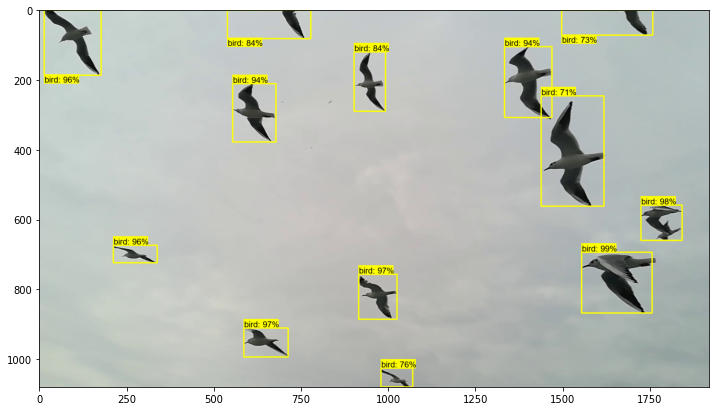

In [67]:
plt.figure(figsize = (12,8))

prediction_result = predict_image("../Data/Test/bird_video_1_200.JPEG", detection_model)
plt.imshow(prediction_result)